In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 24.7MB/s 
     |████████████████████████████████| 901kB 49.8MB/s 
     |████████████████████████████████| 3.3MB 52.2MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
#%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")
  print(device)

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
EPOCHS = 10 #BERT Recommend using 2-4 EPOCH
LEARNING_RATE = 5e-5 #5e-5, 3e-5 or 2e-5
DROPOUT = 0.4

In [ ]:
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')

softmax_layer_5e-05_0.4_4.bin


In [ ]:
type(DROPOUT)

float

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Skripsi/datasetBeritaFIX.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Skripsi/train_berita.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Skripsi/test_berita.csv')

In [ ]:
class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']
test_df['list_kategori'] = list(test_df[class_names].values)
train_df['list_kategori'] = list(train_df[class_names].values)

In [ ]:
train_df=train_df.drop(columns=class_names)
test_df=test_df.drop(columns=class_names)

In [ ]:
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)

MAX_LEN = 400

In [ ]:
import statistics
sent_length = []

# For every sentence...
for sent in train_df.preprocessing_text:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  321.4751052761952
Median length =  283


In [ ]:
#Classify
class DatasetBerita(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
train_df, val_df = train_test_split(
  train_df,
  test_size=0.20, # train 80% val 20%
  random_state=RANDOM_SEED
)

In [ ]:
train_df

,judul,url,isi,kategori,preprocessing_text,list_kategori
3602,"Google Hentikan Project ""Balon Internet"" Loon",https://tekno.kompas.com/read/2021/01/22/11450...,"\n - Perusahaan induk Google, Alphabet berenca...",tekno,usaha induk google alphabet rencana henti proy...,"[0, 1, 0, 0, 0]"
2768,Motorola Gebrak 2021 dengan Flagship Terjangk...,https://tekno.sindonews.com/read/288974/122/mo...,Motorola siap untuk meluncurkan dua perangkat...,tekno,motorola siap luncur perangkat baru kuartal da...,"[0, 1, 0, 0, 0]"
3033,Malaysia Kirim Skuad Timnas U-19 ke SEA Games...,https://sports.sindonews.com/read/301414/11/ma...,Federasi sepak bola Malaysia (FAM) memutuskan...,sports,federasi sepak bola malaysia fam putus kirim t...,"[0, 0, 1, 0, 0]"
170,7 Langkah Pengisian PDSS SNMPTN 2021,https://www.kompas.com/edu/read/2021/01/12/104...,\n\n - Lembaga Tes Masuk Perguruan Tinggi (LTM...,edukasi,lembaga tes masuk guru tinggi ltmpt aku isi pa...,"[1, 0, 0, 0, 0]"
1082,Mulut Berdarah dan Nyeri Bisa Jadi Awal Kanker...,https://health.kompas.com/read/2021/01/09/1800...,\n\n Jika mulut Anda berdarah atau nyeri berke...,health,mulut darah nyeri panjang jangan abai bisa jad...,"[0, 0, 0, 1, 0]"
...,...,...,...,...,...,...
4283,Monitor Ergo Series Bawa Konsep Ergonomis dan...,https://tekno.sindonews.com/read/310072/123/mo...,"Membuka lembaran tahun baru, LG Electronics ...",tekno,buka lembar tahun baru lg electronics indonesi...,"[0, 1, 0, 0, 0]"
2216,Ampas Kopi Bisa Hilangkan Bau Tak Sedap di Kam...,https://lifestyle.kompas.com/read/2021/01/12/0...,\n - Mencium bau tak sedap di kamar mandi buka...,lifestyle,cium bau tak sedap kamar mandi bukan kurang se...,"[0, 0, 0, 0, 1]"
4053,Apple Pangkas 2 Juta Produksi iPhone 12 Mini,https://tekno.sindonews.com/read/309996/765/ap...,Apple dilaporkan telah memangkas produksi iPh...,tekno,apple lapor mangkas produksi iphone mini banya...,"[0, 1, 0, 0, 0]"
2205,Sembuh dari COVID-19 Jadi Kado Ulang Tahun Ni...,https://lifestyle.sindonews.com/read/296488/18...,Nirina Zubir mengumumkan kabar bahagia tepat ...,lifestyle,nirina zubir umum kabar bahagia tepat hari ula...,"[0, 0, 0, 0, 1]"


In [ ]:
val_df

,judul,url,isi,kategori,preprocessing_text,list_kategori
687,Begini Cara Ikuti Cover Song Contest Soundtra...,https://lifestyle.sindonews.com/read/290674/15...,Setelah sukses merilis 2 pencarian bakat pada...,lifestyle,sukses rilis cari bakat oktober lalu bike for ...,"[0, 0, 0, 0, 1]"
3213,Tayang Perdana Hari Ini! Original Series Visi...,https://lifestyle.sindonews.com/read/318348/15...,"Sukses merilis beberapa judul, aplikasi penye...",lifestyle,sukses rilis beberapa judul aplikasi sedia lay...,"[0, 0, 0, 0, 1]"
4211,"Memaknai Efikasi Vaksin Sinovac 65,3 %",https://lifestyle.sindonews.com/read/298480/15...,"Saat yang ditunggu-tunggu tiba, yaitu pengumu...",health,ditunggutunggu tiba umum hasil uji klinik vaks...,"[0, 0, 0, 1, 0]"
2051,3 Hoaks WhatsApp yang Wajib Diwaspadai Pengguna,https://tekno.kompas.com/read/2021/01/31/19200...,\n - WhatsaApp menjadi salah satu aplikasi pes...,tekno,whatsaapp jadi salah satu aplikasi pesan insta...,"[0, 1, 0, 0, 0]"
2663,12 Cara Atasi Rasa Sedih Saat Kehilangan Orang...,https://lifestyle.kompas.com/read/2021/01/10/1...,\n Semua orang pasti akan mengalami kehilangan...,lifestyle,semua orang alami hilang entah putus cinta cer...,"[0, 0, 0, 0, 1]"
...,...,...,...,...,...,...
3528,Samsung Galaxy S21 Series Dijual Tanpa Charge...,https://tekno.sindonews.com/read/302070/122/sa...,Rumor mengenai ketiadaan charger di kotak pem...,tekno,rumor kena tiada charger kotak beli samsung ga...,"[0, 1, 0, 0, 0]"
1586,"Ada Fitur Transaksi Non-Tunai Baru di DANA, A...",https://tekno.sindonews.com/read/288778/207/ad...,Wabah virus Corona baru telah memaksa masyara...,tekno,wabah virus corona baru paksa masyarakat ubah ...,"[0, 1, 0, 0, 0]"
2682,"Man United Vs Liverpool, Pening Kepala Juergen...",https://www.kompas.com/sports/read/2021/01/25/...,\n\n - Juergen Klopp pusing tujuh keliling mel...,sports,juergen klopp pusing tujuh keliling lihat tren...,"[0, 0, 1, 0, 0]"
1092,"Kasus Covid-19 Melonjak, Sikap Keras Kepala L...",https://sports.sindonews.com/read/298452/11/ka...,Liga Primer Inggris mencatat ada 36 kasus bar...,sports,liga primer inggris catat kasus baru covid pan...,"[0, 0, 1, 0, 0]"


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DatasetBerita(
    reviews=df.preprocessing_text.to_numpy(), #berdasarkan table di df
    targets=df.list_kategori.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Klasifikasi(nn.Module):

  def __init__(self, n_classes, dropout_value):
    super(Klasifikasi, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
    self.drop = nn.Dropout(p=dropout_value)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(pooled_output)

In [ ]:
#from transformers import BertForSequenceClassification
#model = BertForSequenceClassification.from_pretrained(
#    PRE_TRAINED_MODEL_BAHASA, # Use the 12-layer BERT model, with an cased vocab.
#    num_labels = len(class_names), 
#    output_attentions = False, # return attentions weights
#    output_hidden_states = False, # returns all hidden-states
#)
#model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
model = Klasifikasi(len(class_names), DROPOUT)
model = model.to(device)

In [ ]:

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
#TESTTTTTTTTTTTTTTTTTTTT
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler
):
  model = model.train()

  losses = []
  #correct_predictions = 0

  pred_labels = []
  true_labels = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #_, preds = torch.max(outputs, dim=1)
    
    loss = loss_fn(outputs, torch.max(targets.float(), 1)[1])

    outputs = F.softmax(outputs,dim=1)
    #correct_predictions += torch.sum(torch.max(outputs, 1)[1] == torch.max(targets, 1)[1])

    b_probs = outputs.detach().cpu().numpy()
    b_targets = targets.detach().cpu().numpy()

    true_labels.append(b_targets)
    pred_labels.append(b_probs)

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    #print(f'train acc {correct_predictions.double() / n_examples} acc1 {accuracy_score(true_bools, pred_bools)} loss {np.mean(losses)} ')
  
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]

  return accuracy_score(true_bools, pred_bools), np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  #correct_predictions = 0

  pred_labels = []
  true_labels = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      #_, preds = torch.max(outputs, dim=1)

      #loss = outputs['loss']
      loss = loss_fn(outputs, torch.max(targets.float(), 1)[1])

      outputs = F.softmax(outputs,dim=1)
      #outputs = F.softmax(outputs,dim=1)
      #correct_predictions += torch.sum(torch.max(outputs, 1)[1] == torch.max(targets, 1)[1])

      b_probs = outputs.detach().cpu().numpy()
      b_targets = targets.detach().cpu().numpy()

      true_labels.append(b_targets)
      pred_labels.append(b_probs)
      losses.append(loss.item())

      #print(f'val acc {correct_predictions.double() / n_examples} acc1 {accuracy_score(true_bools, pred_bools)} loss {np.mean(losses)} ')

  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]

  return accuracy_score(true_bools, pred_bools), np.mean(losses)

In [ ]:
#%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_0.3_{EPOCHS}.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.4567713817966638 accuracy 0.847556142668428
Val   loss 0.31896242249426965 accuracy 0.9064976228209192
Epoch 2/4
----------
Train loss 0.21475066495902112 accuracy 0.9402906208718627
Val   loss 0.3405433099693324 accuracy 0.9120443740095087
Epoch 3/4
----------
Train loss 0.13338005612113116 accuracy 0.9648612945838837
Val   loss 0.270905899638428 accuracy 0.9310618066561014
Epoch 4/4
----------
Train loss 0.08520645893057062 accuracy 0.9775429326287979
Val   loss 0.2952044603173161 accuracy 0.9350237717908082


In [ ]:
#%%time
#SOFTMAXLAYER_5e-05_0.4_4.bin (LEARNINGRATE, DROPOUT_VALUE, EPOCHS)
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.6313678752395171 accuracy 0.7947159841479524
Val   loss 0.4763092867841449 accuracy 0.8700475435816165
Epoch 2/4
----------
Train loss 0.40681313745331665 accuracy 0.8795244385733157
Val   loss 0.42996682603902453 accuracy 0.8771790808240888
Epoch 3/4
----------
Train loss 0.34578251582472136 accuracy 0.8961690885072655
Val   loss 0.39424175391846067 accuracy 0.8938193343898574
Epoch 4/4
----------
Train loss 0.32495339687929375 accuracy 0.9011889035667107
Val   loss 0.3880759423858003 accuracy 0.8969889064976229


In [ ]:
#%%time
#SOFTMAXLAYER_5e-05_0.4_4.bin (LEARNINGRATE, DROPOUT_VALUE, EPOCHS)
history = defaultdict(list)
best_accuracy = 0
print(f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}')

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_{LEARNING_RATE}_{DROPOUT}_{EPOCHS}.bin')
    best_accuracy = val_acc

softmax_layer_5e-05_0.4_10
Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.2044086961369767 accuracy 0.3556803170409511
Val   loss 1.136823462943236 accuracy 0.5508586525759577
Epoch 2/10
----------
Train loss 1.0755089032022576 accuracy 0.4808454425363276
Val   loss 1.1567189345757167 accuracy 0.32100396301188905
Epoch 3/10
----------
Train loss 1.0409708264626956 accuracy 0.5260898282694848
Val   loss 1.1815036262075107 accuracy 0.48745046235138706
Epoch 4/10
----------
Train loss 1.1804541876441554 accuracy 0.12648612945838839
Val   loss 1.2791653523842494 accuracy 0.10303830911492734
Epoch 5/10
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f918e28d4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-995fd2a323e1>", line 18, in <module>
    scheduler
  File "<ipython-input-19-7c49c2a09841>", line 41, in train_epoch
    loss.backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/tensor.py", line 245, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 147, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'Keyboard

KeyboardInterrupt: ignored

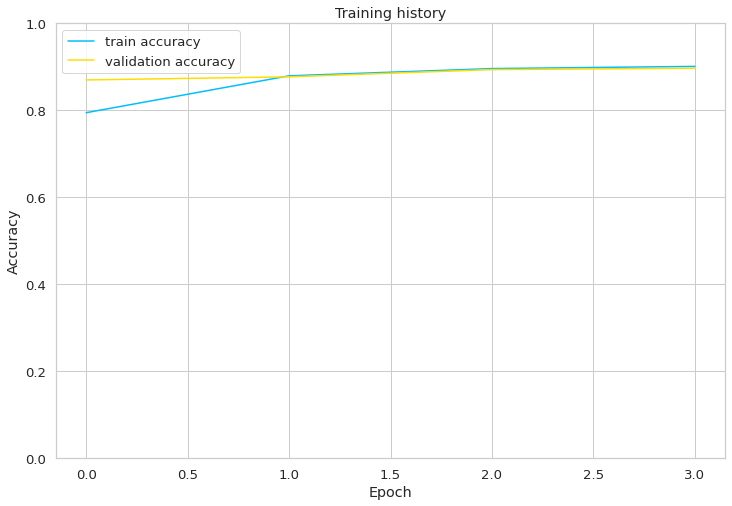

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

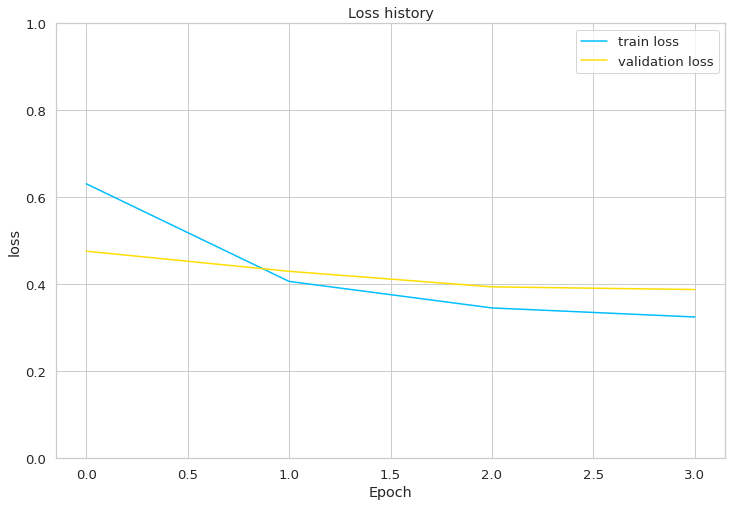

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9057052297939778

In [ ]:
from sklearn.model_selection import GridSearchCV
"""params = {
    'lr': [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_epochs': list(range(500,5500, 500))
}"""
params = {
  "per_gpu_batch_size": [16, 32],
  "learning_rate": [1e-5, 2e-5, 3e-5, 4e-5, 5e-5],
  "num_epochs": [2, 3, 4]
}
gs = GridSearchCV(model, params, refit=False, scoring='r2', verbose=1, cv=10)

In [ ]:
gs.fit()

In [ ]:
isi_berita = '''
Tragedi tenggelamnya kapal selam Naggala-402 menjadi duka bagi seluruh rakyat Indonesia.
Setelah dinyatakan tenggelam pada Sabtu (24/4/2021), status KRI Nanggala-402 diumumkan sebagai On Eternal Patrol atau dapat diartikan sebagai tugas selamanya (tidak kembali lagi)
Tapi tahukah kamu, selain KRI Nanggala-402, TNI Angkatan Laut Republik Indonesia memiliki 4 kapal selam lainnya. Ternyata nama kapal selam milik TNI AL RI ini berasal dari nama senjata dalam dunia pewayangan lho.
Mengutip dari Instagram resmi Kementerian Pendidikan dan Kebudayaan (Kemendikbud), kali ini Kompas.com akan merangkumnya untuk kamu.

1. KRI Cakra-401
Nama kapal selam KRI Cakra-401 berasal dari kata cakra, yaitu nama senjata sakti milik Dewa Wisnu (Batara Guru) yang bernama Cakra Sudarsana.
Dalam dunia pewayangan, cakra digambarkan sebagai panah berbentuk bulat seperti roda bergerigi dan mampu mengakhiri kehidupan segala makhluk hidup.

2. KRI Nanggala-402
Nama KRI Nanggala-402 berasal dari kata Nanggala. Nanggala adalah panah besar milik Baladewa, kesatria tertangguh dalam dunia pewayangan yang mewarisi kekuatan para dewa di angkasa.
Nanggala diceritakan sebagai senjata yang mampu membelah lautan dan menghancurkan gunung serta matahari hanya dalam sekali pelesat.
Nanggala tersimpan dalam tubuh Baladewa dan dikeluarkan hanya saat dibutuhkan.

3. KRI Nagapasa-403
Nagapasa adalah nama milik Indrajit-putra Rahwana-yang mampu mengeluarkan ribuan naga untuk mencabik-cabik musuhnya.
Indrajit memiliki nama kecil Megananda, karena ia dipercaya akan menjadi kesatria yang hebat sebab tangisan pertamanya saat lahir diiringi sura petir menggelegar.
4. KRI Ardadedali-404
Nama KRI Ardadedali-404 berasal dari kata Ardadedali yaitu panah milik Arjuna, putra ketiga Pandawa yang berparas menawan dan berbudi luhur.

Ardadedali merupakan senjata yang dahsyat dan digunakan untuk pertempuran besar.
Ardadedali berbentuk seperti burung dan memiliki jiwa. Saat ia dilepaskan, maka paruh burungnya akan melumpuhkan musuh dengan cara mematuknya.
5. KRI Alugoro-405
Nama KRI Alugoro-405 berasal dari kata Alugara yaitu nama gada milik Baladewa yang memiliki daya pemusnah dahsyat.

Pusaka tersebut merupakan hadiah pernikahan untuk Baladewa dan Dewa Erawati dari Batara Guru.
Itulah nama 5 kapal selam yang dimiliki TNI Angkatan Laut Republik Indonesia.
'''

model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

In [ ]:
prob = F.softmax(output, dim=1)

In [ ]:
prob

tensor([[9.9247e-01, 5.5617e-03, 2.8953e-04, 3.0153e-04, 1.3815e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
prob[:, 1]

tensor([0.0056], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
temp_labels=[]
for a in range(len(prob)):
    text = ""

    indeks = 0
    for b in range(len(prob[a])):
      if(prob[a][b]>0.5):
        indeks+=1
        if indeks==1:
          text += "%s"%(class_names[b])
        else:
          text += ", %s"%(class_names[b])
        #print(text)
    temp_labels.append(text)

In [ ]:
temp_labels

['tekno']

In [ ]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
outputs = eval_model_test_multilabel(
  model,
  test_data_loader,
  loss_fn,
  device
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
outputs

(0.22659968249499798, 0.7654516640253566)

In [ ]:
test_data_loader.shape

AttributeError: ignored

In [ ]:
outputs

(0.22659968249499798, 0.7654516640253566)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
def get_predictions2(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      prob = F.sigmoid(outputs)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(prob)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
def get_predictions_text(model, text, max_len, threshold):
  model = model.eval()
  preds_label = []
  encoded_review = tokenizer.encode_plus(
    text,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  #_, preds = torch.max(output, dim=1)
  probs = F.sigmoid(output)
  probs = probs.detach().cpu().numpy()
  for a in range(len(probs[0])):
    if(probs[0][a]>threshold):
      preds_label.append(class_names[a])
  return preds_label

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))
#print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     edukasi       1.00      0.93      0.97        91
       tekno       0.95      0.95      0.95        95
      sports       0.99      0.99      0.99       224
      health       0.79      0.92      0.85        36
   lifestyle       0.94      0.94      0.94       185

   micro avg       0.96      0.96      0.96       631
   macro avg       0.93      0.95      0.94       631
weighted avg       0.96      0.96      0.96       631
 samples avg       0.96      0.96      0.96       631



In [ ]:
idx = 192
review_text = y_review_texts[idx]
class_ids = y_test[idx]
class_pred = y_pred[idx]
predprobs = y_pred_probs[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
#250 269
isi_berita = '''hp keluaran apple adalah iphone. olahraga sangat menyenangkan dan menyehatkan'''
predstext = get_predictions_text(model, isi_berita , MAX_LEN, 0.5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(predstext)

#for a in range(len(predstext)):
#  index = 0
#  print(class_names[index])
#  index+=1
  #if (float(class_names[a])>threshold):
  #  print(class_names[a])

['tekno', 'lifestyle']


In [ ]:
predstext[0]

array([0.08990626, 0.17553002, 0.99940014, 0.05432682, 0.17469932],
      dtype=float32)

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[class_ids]}')
print(class_names)
print(class_ids)
print(class_pred)
print(predprobs)

timnas u indonesia harus tel pil pahit turnamen piala asia u tahun
resmi batal konfederasi sepak bola asia afc afc resmi batal piala asia
u konfirmasi lalu surat kirim satu sepak bola seluruh indonesia pssi
jumat adapun faktor buat turnamen sebut batal wabah covid landa
seluruh dunia piala asia u kemudian ganti nama jadi piala asia u
langsung tahun uzbekistan tetap jadi tuan rumah dengan batal kompetisi
main timnas u rasa kecewa apalagi skuad garuda muda laku rangkai pusat
latih tc mentas turnamen sepak bola antarnegara asia itu namun main
minta tak tak patah semangat jalan karier bagas kaffa dkk indonesia
panjang lebih ada beberapa turnamen tingkat usia lain bisa ikut main
pasuk level timnas senior kami coba terus beri motivasi karier masih
panjang kata asisten latih timnas u nova arianto kutip bolasportcom
sabtu banyak event akan hadir mereka main timnas u lanjut mereka akan
ikut saat sampai level timnas senior jelas pria usia tahun itu belum
ajang piala dunia u langsung indonesia te

# **LOAD BERT MODEL**

In [ ]:
class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']
class Klasifikasi(nn.Module):

  def __init__(self, n_classes):
    super(Klasifikasi, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)

MAX_LEN = 400
BATCH_SIZE = 16

In [ ]:


#model = model.to(device)
model = Klasifikasi(len(class_names))
model.load_state_dict(torch.load("/content/drive/MyDrive/Skripsi/model/isiberita_epoch4.bin", map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
model.to(device)

Klasifikasi(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
isi_berita = '''
timnas u indonesia harus tel pil pahit turnamen piala asia u tahun
resmi batal konfederasi sepak bola asia afc afc resmi batal piala asia
u konfirmasi lalu surat kirim satu sepak bola seluruh indonesia pssi
jumat adapun faktor buat turnamen sebut batal wabah covid landa
seluruh dunia piala asia u kemudian ganti nama jadi piala asia u
langsung tahun uzbekistan tetap jadi tuan rumah dengan batal kompetisi
main timnas u rasa kecewa apalagi skuad garuda muda laku rangkai pusat
latih tc mentas turnamen sepak bola antarnegara asia itu namun main
minta tak tak patah semangat jalan karier bagas kaffa dkk indonesia
panjang lebih ada beberapa turnamen tingkat usia lain bisa ikut main
pasuk level timnas senior kami coba terus beri motivasi karier masih
panjang kata asisten latih timnas u nova arianto kutip bolasportcom
sabtu banyak event akan hadir mereka main timnas u lanjut mereka akan
ikut saat sampai level timnas senior jelas pria usia tahun itu belum
ajang piala dunia u langsung indonesia telah putus tunda hingga adapun
indonesia masih akan tindak tuan rumah piala dunia u abdul rohman
'''
model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

In [ ]:
predstext

['tekno', 'lifestyle']

In [ ]:
def get_predictions_test(model, data_loader):
  model = model.eval()
  temp = []
  real_values = []
  probs_labels = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      real_values.extend(targets)
      probs_labels.extend(F.sigmoid(outputs))
  
  probs_labels = torch.stack(probs_labels).cpu()
  real_values = torch.stack(real_values).cpu()

  return probs_labels, real_values

In [ ]:
y_pred_probs, y_test = get_predictions_test(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
def SubmissionTest(df, y_pred_prob):
  temp_labels=[]
  for a in range(len(y_pred_prob)):
    text = ""

    indeks = 0
    for b in range(len(y_pred_prob[a])):
      if(y_pred_prob[a][b]>0.5):
        indeks+=1
        if indeks==1:
          text += "%s"%(class_names[b])
        else:
          text += ", %s"%(class_names[b])
        #print(text)
    temp_labels.append(text)

  test_df['y_true_prediction'] = temp_labels
  
  test_df.drop(columns='kategori_int')
  test_df.to_csv('submission.csv', index=False, encoding='utf-8')

    

In [ ]:
SubmissionTest(test_df, y_pred_probs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_pred_probs[0]

tensor([0.0041, 0.6452, 0.0010, 0.0017, 0.6047])